Mounted at /content/drive
Extracting clean zip: /content/drive/MyDrive/MIC.zip
Extracting noise zip: /content/drive/MyDrive/DKITCHEN_16k.zip
Extracting noise zip: /content/drive/MyDrive/NPARK_16k.zip
Extracting noise zip: /content/drive/MyDrive/OHALLWAY_16k.zip
Extracting noise zip: /content/drive/MyDrive/PSTATION_16k.zip
Extracting noise zip: /content/drive/MyDrive/NFIELD_16k.zip
Extracting noise zip: /content/drive/MyDrive/NRIVER_16k.zip
Extracting noise zip: /content/drive/MyDrive/DLIVING_16k.zip
Extracting noise zip: /content/drive/MyDrive/DWASHING_16k.zip
Speakers found: ['F01', 'F02', 'F03', 'F04', 'F05', 'M01', 'M02', 'M03', 'M04', 'M05']
✅ Train clean: 1888 | Val clean: 472 | Noise: 128
✅ Data ready | Train: 236 | Val: 59
✅ Model ready on cpu


/tmp/ipython-input-2456804154.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(USE_AMP and device.type == "cuda"))



🚀 Starting training...



/tmp/ipython-input-2456804154.py:282: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(USE_AMP and device.type == "cuda")):
/tmp/ipython-input-2456804154.py:301: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(USE_AMP and device.type == "cuda")):


Epoch 001/100 | Train: 0.2486 | Val: 0.2018
  💾 Best model saved.
Epoch 002/100 | Train: 0.1920 | Val: 0.1891
  💾 Best model saved.
Epoch 003/100 | Train: 0.1860 | Val: 0.1993
Epoch 004/100 | Train: 0.1814 | Val: 0.1798
  💾 Best model saved.
Epoch 005/100 | Train: 0.1780 | Val: 0.1805
Epoch 006/100 | Train: 0.1762 | Val: 0.1784
  💾 Best model saved.
Epoch 007/100 | Train: 0.1764 | Val: 0.2200
Epoch 008/100 | Train: 0.1719 | Val: 0.2227
Epoch 009/100 | Train: 0.1732 | Val: 0.1758
  💾 Best model saved.
Epoch 010/100 | Train: 0.1730 | Val: 0.1966
Epoch 011/100 | Train: 0.1703 | Val: 0.1750
  💾 Best model saved.
Epoch 012/100 | Train: 0.1688 | Val: 0.1948
Epoch 013/100 | Train: 0.1681 | Val: 0.1891
Epoch 014/100 | Train: 0.1688 | Val: 0.1793
Epoch 015/100 | Train: 0.1683 | Val: 0.1743
  💾 Best model saved.
Epoch 016/100 | Train: 0.1670 | Val: 0.1769
Epoch 017/100 | Train: 0.1649 | Val: 0.2618
Epoch 018/100 | Train: 0.1652 | Val: 0.2035
Epoch 019/100 | Train: 0.1666 | Val: 0.1831
Epoch 020/

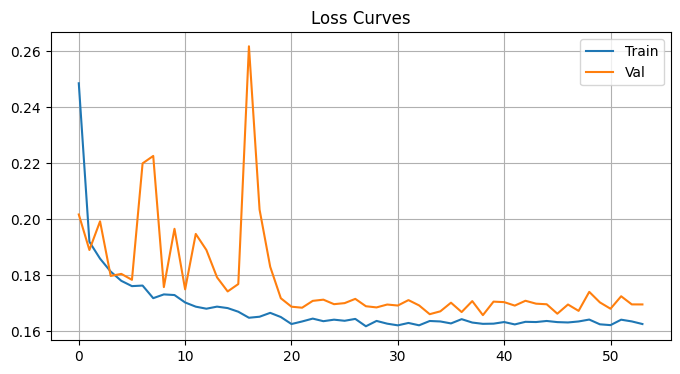

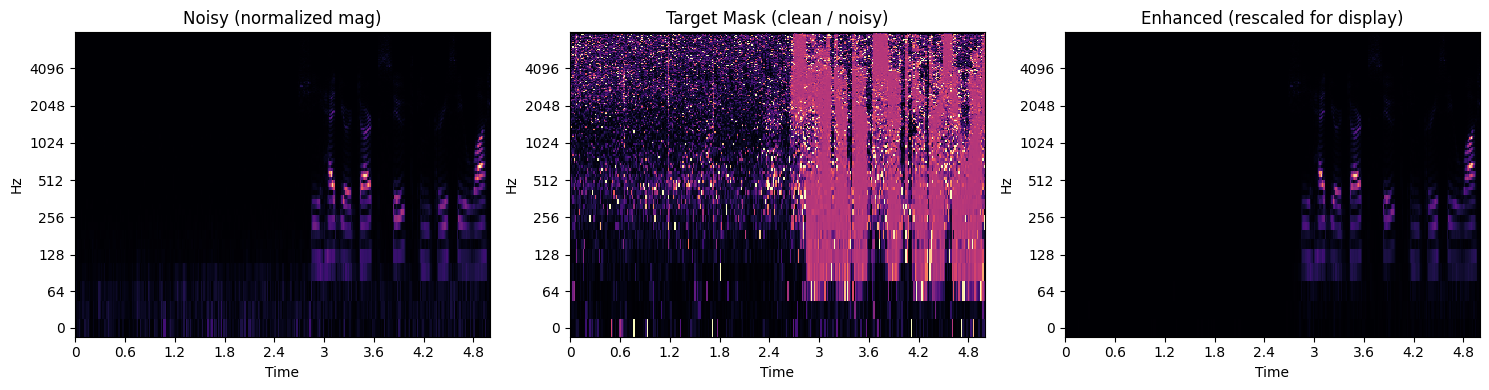

🔊 Noisy:


🔊 Enhanced:


In [ ]:
# ---------------------------
# 0) INSTALLS
# ---------------------------
!pip install -q librosa soundfile matplotlib torch torchvision torchaudio seaborn

# ---------------------------
# 1) IMPORTS
# ---------------------------
import os, random, glob, zipfile
import numpy as np
import librosa, soundfile as sf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

from google.colab import drive
import IPython.display as ipd

# ---------------------------
# 2) PARAMETERS
# ---------------------------
SR = 16000
DURATION = 5.0
TARGET_LEN = int(SR * DURATION)
N_FFT = 512
HOP_LENGTH = 256

BATCH_SIZE = 8
NUM_EPOCHS = 100
LR = 5e-5
WEIGHT_DECAY = 1e-5
PATIENCE = 15
USE_AMP = True

# Paths (update if needed)
CLEAN_ZIP_PATH = "/content/drive/MyDrive/MIC.zip"
NOISE_ZIP_PATHS = [
    "/content/drive/MyDrive/DKITCHEN_16k.zip",
    "/content/drive/MyDrive/NPARK_16k.zip",
    "/content/drive/MyDrive/OHALLWAY_16k.zip",
    "/content/drive/MyDrive/PSTATION_16k.zip",
    "/content/drive/MyDrive/NFIELD_16k.zip",
    "/content/drive/MyDrive/NRIVER_16k.zip",
    "/content/drive/MyDrive/DLIVING_16k.zip",
    "/content/drive/MyDrive/DWASHING_16k.zip"
]

CLEAN_DATASET_DIR = "/content/clean_dataset"
NOISE_DATASET_DIR = "/content/noise_dataset"

# ---------------------------
# 3) MOUNT DRIVE + UNZIP
# ---------------------------
drive.mount('/content/drive', force_remount=True)

os.makedirs(CLEAN_DATASET_DIR, exist_ok=True)
os.makedirs(NOISE_DATASET_DIR, exist_ok=True)

print("Extracting clean zip:", CLEAN_ZIP_PATH)
with zipfile.ZipFile(CLEAN_ZIP_PATH, 'r') as zf:
    zf.extractall(CLEAN_DATASET_DIR)

for p in NOISE_ZIP_PATHS:
    if os.path.exists(p):
        print("Extracting noise zip:", p)
        with zipfile.ZipFile(p, 'r') as zf:
            zf.extractall(NOISE_DATASET_DIR)
    else:
        print("⚠️ Missing noise zip:", p)

# ---------------------------
# 4) COLLECT FILES
# ---------------------------
mic_inner = os.path.join(CLEAN_DATASET_DIR, "MIC")
CLEAN_ROOT = mic_inner if os.path.exists(mic_inner) else CLEAN_DATASET_DIR

speaker_folders = sorted([d for d in os.listdir(CLEAN_ROOT) if os.path.isdir(os.path.join(CLEAN_ROOT, d))])
print("Speakers found:", speaker_folders)

train_speakers = speaker_folders[:8]
val_speakers = speaker_folders[8:] if len(speaker_folders) > 8 else speaker_folders[-2:]

train_clean_files, val_clean_files = [], []
for spk in speaker_folders:
    path = os.path.join(CLEAN_ROOT, spk)
    wavs = sorted(glob.glob(os.path.join(path, "*.wav")))
    if spk in train_speakers:
        train_clean_files.extend(wavs)
    else:
        val_clean_files.extend(wavs)

noise_files = sorted(glob.glob(os.path.join(NOISE_DATASET_DIR, "**/*.wav"), recursive=True))
print(f"✅ Train clean: {len(train_clean_files)} | Val clean: {len(val_clean_files)} | Noise: {len(noise_files)}")

# ---------------------------
# 5) MIXING FUNCTION
# ---------------------------
def mix_with_random_noise(clean, noise_files, sr=SR, target_len=TARGET_LEN):
    """Mix a clean sample with a random noise file at random SNR (0–20 dB)."""
    clean = librosa.util.fix_length(clean, size=target_len)

    noise_path = random.choice(noise_files)
    noise, _ = librosa.load(noise_path, sr=sr)

    # trim/pad noise
    if len(noise) > target_len:
        start = random.randint(0, len(noise) - target_len)
        noise = noise[start:start + target_len]
    else:
        noise = np.pad(noise, (0, target_len - len(noise)))

    # slight augmentations
    if random.random() < 0.25:
        try:
            semitone_shift = random.uniform(-0.5, 0.5)
            clean = librosa.effects.pitch_shift(y=clean, sr=sr, n_steps=semitone_shift)
            clean = librosa.util.fix_length(clean, size=target_len)
        except Exception:
            pass

    if random.random() < 0.25:
        try:
            speed = random.uniform(0.9, 1.1)
            noise = librosa.effects.time_stretch(noise, rate=speed)
            noise = librosa.util.fix_length(noise, size=target_len)
        except Exception:
            pass

    # random SNR
    snr_db = random.uniform(0, 20)
    rms_clean = np.sqrt(np.mean(clean**2) + 1e-12)
    rms_noise = np.sqrt(np.mean(noise**2) + 1e-12)
    desired_rms_noise = rms_clean / (10 ** (snr_db / 20))
    noise = noise * (desired_rms_noise / (rms_noise + 1e-12))
    noise = noise * random.uniform(0.7, 1.2)

    mixed = clean + noise
    # avoid clipping
    maxv = np.max(np.abs(mixed)) + 1e-12
    if maxv > 1.0:
        mixed = mixed / maxv
    return mixed.astype(np.float32), clean.astype(np.float32)

# ---------------------------
# 6) DATASET (target mask range 0..2)
# ---------------------------
class SpeechMaskDataset(Dataset):
    def __init__(self, clean_files, noise_files, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, augment=True):
        self.clean_files = clean_files
        self.noise_files = noise_files
        self.sr = sr
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.augment = augment

    def __len__(self):
        return len(self.clean_files)

    def __getitem__(self, idx):
        clean_wav, _ = librosa.load(self.clean_files[idx], sr=self.sr)
        mixed_wav, clean_wav = mix_with_random_noise(clean_wav, self.noise_files, sr=self.sr)

        noisy_stft = librosa.stft(mixed_wav, n_fft=self.n_fft, hop_length=self.hop_length)
        clean_stft = librosa.stft(clean_wav, n_fft=self.n_fft, hop_length=self.hop_length)

        noisy_mag = np.abs(noisy_stft)
        clean_mag = np.abs(clean_stft)

        # Compute target mask in a reasonable range (0 .. 2)
        mask = clean_mag / (noisy_mag + 1e-8)
        mask = np.clip(mask, 0.0, 2.0)

        # Normalize mags for stable learning (divide by max of both so values ~0..1)
        max_val = max(1e-8, noisy_mag.max(), clean_mag.max())
        noisy_mag_norm = noisy_mag / max_val
        # store normalized noisy_mag as model input, and store mask normalized w.r.t same max
        mask_norm = mask  # mask was computed from raw mags and is scale-invariant, keep as-is (0..2)
        # convert to torch tensors (C,F,T)
        noisy_tensor = torch.tensor(noisy_mag_norm, dtype=torch.float32).unsqueeze(0)
        mask_tensor = torch.tensor(mask_norm, dtype=torch.float32).unsqueeze(0)

        # also return raw mixed waveform for reconstruction (float32 numpy)
        return noisy_tensor, mask_tensor, mixed_wav.astype(np.float32)

train_dataset = SpeechMaskDataset(train_clean_files, noise_files)
val_dataset = SpeechMaskDataset(val_clean_files, noise_files)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
print(f"✅ Data ready | Train: {len(train_loader)} | Val: {len(val_loader)}")

# ---------------------------
# 7) MODEL
# ---------------------------
class UNetMask(nn.Module):
    def __init__(self):
        super().__init__()
        def down(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, 2, 1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
        def up(in_ch, out_ch):
            return nn.Sequential(
                nn.ConvTranspose2d(in_ch, out_ch, 4, 2, 1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
        self.enc1 = down(1, 16)
        self.enc2 = down(16, 32)
        self.enc3 = down(32, 64)
        self.enc4 = down(64, 128)

        self.dec1 = up(128, 64)
        self.dec2 = up(128, 32)
        self.dec3 = up(64, 16)

        # final conv: produce non-negative mask (Softplus gives smooth positive output)
        self.out_conv = nn.Conv2d(32, 1, 3, 1, 1)
        self.out_activation = nn.Softplus()  # smooth, >=0

    def forward(self, x):
        e1 = self.enc1(x)   # B,16,H/2,W/2
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)

        d1 = self.dec1(e4)
        e3a = F.interpolate(e3, size=d1.shape[2:], mode='bilinear', align_corners=False)
        d1 = torch.cat([d1, e3a], dim=1)

        d2 = self.dec2(d1)
        e2a = F.interpolate(e2, size=d2.shape[2:], mode='bilinear', align_corners=False)
        d2 = torch.cat([d2, e2a], dim=1)

        d3 = self.dec3(d2)
        e1a = F.interpolate(e1, size=d3.shape[2:], mode='bilinear', align_corners=False)
        d3 = torch.cat([d3, e1a], dim=1)

        out = self.out_conv(d3)
        out = self.out_activation(out)  # >= 0
        # allow mask boost up to a cap (helps restore speech energy). we apply clamp later in numpy before reconstruction
        out = F.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=False)
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetMask().to(device)
print("✅ Model ready on", device)

# ---------------------------
# 8) TRAINING
# ---------------------------
mse, l1 = nn.MSELoss(), nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# scheduler compatible with common PyTorch
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)
scaler = torch.cuda.amp.GradScaler(enabled=(USE_AMP and device.type == "cuda"))

train_losses, val_losses = [], []
best_val, patience = float('inf'), 0

print("\n🚀 Starting training...\n")
for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0.0

    for noisy, mask, _ in train_loader:
        noisy, mask = noisy.to(device), mask.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=(USE_AMP and device.type == "cuda")):
            pred = model(noisy)
            # clamp predicted mask in [0, 2.5] during training for stability
            pred_clamped = torch.clamp(pred, 0.0, 2.5)
            loss = 0.7 * mse(pred_clamped, mask) + 0.3 * l1(pred_clamped, mask)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # validation
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for noisy, mask, _ in val_loader:
            noisy, mask = noisy.to(device), mask.to(device)
            with torch.cuda.amp.autocast(enabled=(USE_AMP and device.type == "cuda")):
                pred = model(noisy)
                pred_clamped = torch.clamp(pred, 0.0, 2.5)
                val_loss = 0.7 * mse(pred_clamped, mask) + 0.3 * l1(pred_clamped, mask)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    scheduler.step(avg_val_loss)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1:03}/{NUM_EPOCHS} | Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f}")

    if avg_val_loss < best_val:
        best_val, patience = avg_val_loss, 0
        torch.save(model.state_dict(), "best_mask_unet.pth")
        print("  💾 Best model saved.")
    else:
        patience += 1
        if patience >= PATIENCE:
            print("⛔ Early stopping triggered.")
            break

print("\n✅ Training complete!")

# ---------------------------
# 9) LOSS CURVE
# ---------------------------
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.legend(); plt.grid(); plt.title("Loss Curves")
plt.show()

# ---------------------------
# 10) VISUALIZE + PLAYBACK
# ---------------------------
import librosa.display

# load best model
model.load_state_dict(torch.load("best_mask_unet.pth", map_location=device))
model.eval()

# pick a validation sample
noisy_tensor, target_mask_tensor, mixed_wave = val_dataset[0]
# Convert tensors to proper numpy for plotting and reconstruction
noisy_np = noisy_tensor.squeeze().numpy()        # this is normalized noisy magnitude (normed by max_val in dataset)
target_mask_np = target_mask_tensor.squeeze().numpy()

# Get predicted mask
with torch.no_grad():
    pred_mask = model(noisy_tensor.unsqueeze(0).to(device)).squeeze(0).cpu().numpy()  # (1,F,T) -> (F,T)
pred_mask = pred_mask.squeeze(0)  # shape (F,T)

# clamp predicted mask to safe range (0..2.5)
pred_mask = np.clip(pred_mask, 0.0, 2.5)

# Reconstruct: combine with original noisy STFT magnitude (not the normalized one)
noisy_stft = librosa.stft(mixed_wave, n_fft=N_FFT, hop_length=HOP_LENGTH)
noisy_mag = np.abs(noisy_stft)   # original scale magnitude
noisy_phase = np.angle(noisy_stft)

# Sanity shape align (if shapes mismatch due to rounding)
F_o, T_o = noisy_mag.shape
F_p, T_p = pred_mask.shape
if F_p != F_o or T_p != T_o:
    # interpolate pred_mask to noisy_mag shape
    pred_mask = np.pad(pred_mask, ((0, max(0, F_o - F_p)), (0, max(0, T_o - T_p))), mode='constant')
    pred_mask = pred_mask[:F_o, :T_o]

# enhanced magnitude in real scale = pred_mask * original noisy magnitude
enhanced_mag = pred_mask * noisy_mag

# Reconstruct complex STFT and ISTFT
enh_stft = enhanced_mag * np.exp(1j * noisy_phase)
enh_audio = librosa.istft(enh_stft, hop_length=HOP_LENGTH, length=len(mixed_wave))

# RMS matching: scale enhanced to roughly match mixed_wave RMS (so loudness doesn't drop)
def rms(x): return np.sqrt(np.mean(x**2) + 1e-12)
r_orig = rms(mixed_wave)
r_enh = rms(enh_audio)
if r_enh > 0:
    enh_audio = enh_audio * (r_orig / r_enh)

# Clip to avoid >1/-1
enh_audio = np.clip(enh_audio, -0.99, 0.99)

# Convert to float32 and save/play
sf.write("noisy.wav", mixed_wave.astype(np.float32), SR)
sf.write("enhanced.wav", enh_audio.astype(np.float32), SR)

# Plot spectrograms (use log scaled frequency for readability)
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
librosa.display.specshow(noisy_np, sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='log')
plt.title("Noisy (normalized mag)")

plt.subplot(1,3,2)
librosa.display.specshow(target_mask_np, sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='log')
plt.title("Target Mask (clean / noisy)")

plt.subplot(1,3,3)
# display enhanced magnitude normalized for visualization (to avoid large scale differences)
vis_enh = enhanced_mag / (np.max(enhanced_mag) + 1e-12)
librosa.display.specshow(vis_enh, sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='log')
plt.title("Enhanced (rescaled for display)")

plt.tight_layout()
plt.show()

print("🔊 Noisy:")
display(ipd.Audio("noisy.wav", rate=SR))
print("🔊 Enhanced:")
display(ipd.Audio("enhanced.wav", rate=SR))
